## Notebook for collating metadata and analysed data from all experiments and plotting the results

In [1]:
%run ./rob_setup_notebook.ipynb

import utils.interareal_plotting as ip

try:
    with open(master_path, 'rb') as f:
        master_obj = pickle.load(f)
except: 
    raise Exception('ERROR: Could not load master pickle')


Suite2p path: ['/home/rlees/Documents/Code/suite2p/suite2p']
QNAP_path: /home/rlees/mnt/qnap 
QNAP_data_path /home/rlees/mnt/qnap/Data 
Pickle folder: /home/rlees/mnt/qnap/pkl_files 
Master pickle: /home/rlees/mnt/qnap/master_pkl/master_obj.pkl 
Figure save path: /home/rlees/mnt/qnap/Analysis/Plots 
STA movie save path: /home/rlees/mnt/qnap/Analysis/STA_movies 
S2 borders path: /home/rlees/mnt/qnap/Analysis/S2_borders


### See the variables that are attributed to the master object

In [66]:
print('Attributes of master object:', end='\n\n')
for key, value in vars(master_obj).items():
    print(key, len(value))

Attributes of master object:

pkl_folder 30
pkl_name 8
pkl_path 8
sheet_name 32
stim_type 32
tiff_path 32
fps 32
n_units 32
cell_med 32
cell_s1 32
num_s1_cells 32
num_s2_cells 32
stim_dur 32
stim_freq 32
pre_frames 32
post_frames 32
duration_frames 32
all_trials 32
stas 32
trial_sig_dff 32
trial_sig_dfsf 32
sta_sig 32
sta_sig_nomulti 32
prob_response 32
sta_amplitudes 32
all_amplitudes 32
targeted_cells 32
target_coords 32
n_targets 32
n_targeted_cells 32
trial_target_dff 32
trial_w_targets 32
trial_euclid_dist 32
sta_euclid_dist 32
new_pkls 8


### Add new pickle files to the master object

In [6]:
master_obj.addPickles()

with open(master_path, 'wb') as f:
    pickle.dump(master_obj, f)

### Create master object and collate all analysis from individual experiments

In [65]:
master_obj = ip.interarealPlotting(pkl_folder)

with open(master_path, 'wb') as f:
    pickle.dump(master_obj, f)

In [ ]:
def plotExpAvgDff(exp_obj, threshold, cell_ids):
    
    # all trials for all cells of interest
    cell_trials = np.array(exp_obj.all_trials[0][cell_ids][:][:])
    
    # mean across all trials for each cell
    cell_trial_means = np.nanmean(cell_trials, axis=2)

    # collapse trial mean for each cell in to one number, the overall mean dff
    cell_mean = np.nanmean(cell_trial_means, axis=1)
    
    # find mean dff greater than threshold and filter out
    extreme_means = np.where(abs(cell_mean) > threshold)
    if len(extreme_means[0]) > 0:
        print(len(extreme_means[0]), 'extreme values excluded')
    cell_trial_means = np.delete(cell_trial_means, extreme_means, axis=0)
    
    # make mean and std of traces
    grand_trial_mean = np.nanmean(cell_trial_means, axis=0)
    grand_trial_std = np.nanstd(cell_trial_means, axis=0)
    grand_trial_ci = 1.960 * (grand_trial_std/np.sqrt(len(cell_ids)))
    grand_trial_sem = grand_trial_std/np.sqrt(len(cell_ids))
    
    # construct patch to cover stim artifact period
#     stim_patch = patches.Rectangle((0,-100), exp_obj.duration_frames/fps, 999, zorder=3, color='lightgrey', lw=3, ec='white')
#     ax = plt.gca()
#     ax.add_patch(stim_patch)
    
    # make x axis in continous time units instead of frames
    fps = exp_obj.fps
    x = np.array(range( -exp_obj.pre_frames, exp_obj.post_frames ))/fps
    
    # find minimum and maximum x values (for plotting)
    x_max = np.max(x)
    x_min = np.min(x)
    
    #construct plot
    plt.plot(x, grand_trial_mean, lw=3, zorder=2);
    plt.fill_between(x, grand_trial_mean + grand_trial_ci, grand_trial_mean - grand_trial_ci, alpha=0.6, zorder=1);
    plt.hlines(0, x_min, x_max, linestyles='dashed', zorder=4, alpha=0.3);
    plt.ylim([-0.05, 0.15]);
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.xlabel('time (seconds)');
    plt.ylabel('ΔF/F');
    
    return cell_trial_means

In [95]:
def filterVariablesByExp(master_obj, variable, filter_var, filter_val):
    
    exp_name = [name for i, name in enumerate(master_obj.sheet_name) if filter_var[i] == filter_val]
    filtered_vars = [var for i, var in enumerate(variable) if filter_var[i] == filter_val]
    
    return exp_name, filtered_vars

In [96]:
# def filterVariablesByCell():

# e.g. filter positive amplitudes (within each all_amps, filter > 0)
# filter significant trials based on trial_sig_dff == True

stim_type = 'w'

exp_name, stas = filterVariablesByExp(master_obj, master_obj.stas, master_obj.stim_type, stim_type, 'equal')
_, cell_s1 = filterVariablesByExp(master_obj, master_obj.cell_s1, master_obj.stim_type, stim_type, 'equal')

sta = stas[0]
s1_cells = cell_s1[0]

print(sta, s1_cells)

# cell_s1 # s1 cells
# cell_s2 = np.invert(cell_s1) # s2 cells

[[ 0.00213951 -0.05542952 -0.0206602  ... -0.03267755 -0.02976178
  -0.06816691]
 [-0.12740712  0.09553358  0.04074985 ... -0.1631682  -0.0260112
   0.02096685]
 [ 0.00420892 -0.02005592  0.01094819 ...  0.00520074  0.01466443
   0.01358693]
 ...
 [-0.12829141  0.14278337 -0.0143781  ...  0.00232152  0.17637265
   0.00990549]
 [ 0.04476452 -0.17911541  0.15100075 ...  0.1757469   0.0483775
   0.12829742]
 [-0.17933188 -0.20426455 -0.10272026 ... -0.12747976  0.08071347
  -0.00456017]] [False False  True ... False False  True]


In [92]:
threshold = 3

grand_average = []

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
# labels = []

for stim_type in np.unique(master_obj.stim_type):
    
    exp_name, stas = filterVariablesByExp(master_obj, master_obj.stas, master_obj.stim_type, stim_type)
    _, cell_s1 = filterVariablesByExp(master_obj, master_obj.cell_s1, master_obj.stim_type, stim_type)

#     for exp, sta, cell_s1 in zip(exp_name, stas, cell_s1):
        
        
# Plot all S1 or S2 on same graph, label = stim_type

    

#     for i, ax_id in enumerate([1,0]):

#         in_s1 = np.array(ses_obj.photostim_r.cell_s1[0])
#         cell_ids = np.where(in_s1 == i)[0]

#         plt.sca(ax[ax_id])
#         plt.title('S' + str(ax_id+1))

#         for exp_obj in exp_list:

#             # for filtering sta significant cells with pos/neg amps
# #                 cell_loc = np.where(in_s1 == i)
# #                 sig_cells = np.where(exp_obj.sta_sig[0])
# #                 amps = np.where(exp_obj.sta_amplitudes[0] < 0)
# #                 cell_ids = np.intersect1d(cell_loc[0], sig_cells)
# #                 cell_ids = np.intersect1d(cell_ids, amps)

#             if cell_ids.shape[0] > 0: 
# #                     masked_trials = maskTrials(exp_obj, filt='pos')
# #                     cell_trials = plotExpAvgDffMasked(exp_obj, threshold, cell_ids, masked_trials)

#                 labels.append(master_obj.stim_type)
#                 cell_trials = plotExpAvgDff(exp_obj, threshold, cell_ids)
#                 grand_average.append(cell_trials)

#     fig.suptitle(exp_obj.sheet_name)
#     plt.legend(labels[:len(exp_list)], loc='upper right')

### Plot summary statistics and other analytics


Number of cells responding out of total targeted:
2019-11-14_J061
Similar: 13 out of 49
Random: 40 out of 63
None: 0 out of 63
2019-11-14_J063
Similar: 6 out of 37
Random: 24 out of 39
None: 0 out of 39
2019-11-15_J064
Similar: 14 out of 50
Random: 31 out of 47
None: 0 out of 47
2019-11-18_J065
Similar: 6 out of 42
Random: 20 out of 39
None: 0 out of 39
2020-02-27_RL075
Similar: 22 out of 45
Random: 29 out of 45
None: 0 out of 45
2020-03-03_RL074
Similar: 49 out of 71
Random: 30 out of 46
None: 0 out of 46
2020-03-05_RL070
Similar: 13 out of 41
Random: 28 out of 48
None: 0 out of 48
2020-03-05_RL072
Similar: 29 out of 63
Random: 36 out of 61
None: 0 out of 61


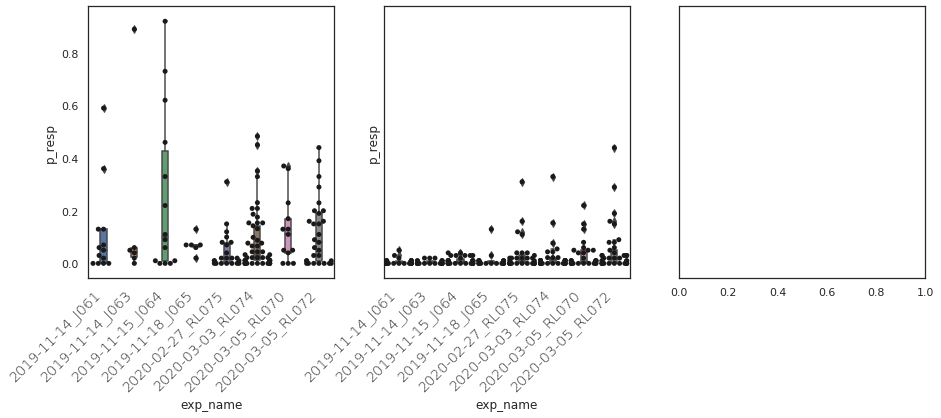

In [4]:
with open(master_path, 'rb') as f:
    master_obj = pickle.load(f)

# Plot probability of response on whisker trials for 'ps' and 'pr' target responders
# master_obj.plotWhiskerBias()
    
# Plot mean STA dFF amplitude across all cells in group
# master_obj.boxplotSummaryStat('target_sta_amp')
# master_obj.boxplotSummaryStat('target_responders_sta')
# master_obj.boxplotSummaryStat('n_targeted_cells')
# plt.savefig(os.path.join(fig_save_path, 'target_sta_amp.svg'))
# master_obj.boxplotSummaryStat('non_target_sta_amp')
# master_obj.boxplotSummaryStat('s2_sta_amp')
# master_obj.boxplotSummaryStat('positive_s2_responders_sta')
# master_obj.boxplotSummaryStat('stim_freq')
# plt.savefig(os.path.join(fig_save_path, 'n_targeted_cells.png'))

# Plot distribution of STA amplitudes across all cells in group
# master_obj.distributionSummaryStat('s2_sta')

# Plot mean STA dFF trace across all cells in group
# master_obj.lineplotSTA('target_sta')
# plt.savefig(os.path.join(fig_save_path, 'target_sta.png'))
# master_obj.lineplotSTA('non_target_sta')
# master_obj.lineplotSTA('s2_sta')

# Plot probability of response for each stim separately for each animal
# master_obj.boxplotProbResponse(to_mask='target_cells')
# plt.savefig(os.path.join(fig_save_path, 'prob_response_boxplot.svg'))

# Plot probability of response for each cell across two different stim types
# master_obj.scatterProbResponse(to_mask='target_cells')
# plt.savefig(os.path.join(fig_save_path, 'prob_response_scatter.svg'))

# Plot reliable responders over 100 trials (STA)
# master_obj.scatterResponseSTA(['target_responders_sta', 'positive_s2_responders_sta'], proportion=False)
# master_obj.scatterResponseSTA(['positive_s1_responders_sta', 'positive_s2_responders_sta'], proportion=True)

# Plot all responders per trial (> 2 S.D. of baseline)
# master_obj.scatterResponseTrial(['target_responders_trial_sum', 'positive_s2_responders_trial'], proportion=True)
# master_obj.scatterResponseTrial(['target_responders_trial_sum', 'positive_s2_responders_trial'])
# master_obj.scatterResponseTrial(['positive_s1_responders_trial', 'positive_s2_responders_trial'], proportion=True)
# master_obj.scatterResponseTrial(['positive_s1_responders_trial', 'positive_s2_responders_trial'])
# master_obj.scatterResponseTrial(['target_sum_dff', 'positive_s2_responders_trial'])
# master_obj.scatterResponseTrial(['num_whisker_targets', 'positive_s2_responders_trial'])
# master_obj.scatterResponseTrial(['euclid_dist', 'positive_s2_responders_trial'])

# Plot whisker bias of targets
master_obj.boxplotWhiskerBias()
# plt.savefig(os.path.join(fig_save_path, 'prob_response_whisker_targets.png'))

In [3]:
df = master_obj.df
print(df.columns)

Index(['sheet_name', 'tiff_path', 'stim_type', 'fps', 'n_units', 's1_cells',
       's2_sta', 's2_sta_amp', 's2_sta_std', 's1_sta', 's1_sta_amp',
       's1_sta_std', 'num_s1_cells', 'num_s2_cells',
       'positive_s1_responders_trial', 'negative_s1_responders_trial',
       'positive_s2_responders_trial', 'negative_s2_responders_trial',
       'positive_s1_responders_sta', 'negative_s1_responders_sta',
       'positive_s2_responders_sta', 'negative_s2_responders_sta',
       'positive_s1_responders_sta_nomulti',
       'negative_s1_responders_sta_nomulti',
       'positive_s2_responders_sta_nomulti',
       'negative_s2_responders_sta_nomulti', 'prob_response', 'n_targets',
       'target_cells', 'n_targeted_cells', 'stim_dur', 'stim_freq',
       'target_sta', 'target_sta_amp', 'target_sta_std', 'non_target_sta',
       'non_target_sta_amp', 'non_target_sta_std', 'target_responders_trial',
       'target_responders_trial_sum', 'target_responders',
       'target_responders_sta', 'ta

In [12]:
master_obj.df
# master_obj.df[['tiff_path', 'stim_type', 'n_targeted_cells', 'target_responders_sta']]
# master_obj.df.describe().transpose()

,sheet_name,tiff_path,stim_type,fps,n_units,s1_cells,s2_sta,s2_sta_amp,s2_sta_std,s1_sta,...,non_target_sta_amp,non_target_sta_std,target_responders_trial,target_responders_trial_sum,target_responders,target_responders_sta,target_responders_sta_nomulti,target_sum_dff,num_whisker_targets,euclid_dist
0,2019-11-14_J061,2019-11-14_J061_t-007,pr,15.023208,1972,"[False, False, True, False, True, False, False...","[-0.003658379, 0.00063539774, -0.0054637855, -...",-0.000210,"[0.088237114, 0.08113342, 0.08867555, 0.101278...","[-0.00060495717, -0.011596499, 0.003943409, 0....",...,0.000697,"[0.15761642, 0.11305486, 0.11012849, 0.1370268...","[[False, False, False, False, False, False, Fa...","[26, 23, 19, 15, 15, 14, 18, 18, 21, 14, 12, 1...","[False, False, False, False, False, False, Fal...",40.0,48.0,"[90.72529602050781, 53.25263595581055, 52.7428...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[174.18425363957655, 199.31850455261008, 189.5..."
1,2019-11-14_J061,2019-11-14_J061_t-006,ps,15.220141,1972,"[False, False, True, False, True, False, False...","[-0.0005377551, 0.0025310002, -0.002039906, -0...",0.011227,"[0.09598932, 0.07189933, 0.08526749, 0.0837057...","[0.0035585065, 0.003017501, 0.000586165, 0.002...",...,-0.000995,"[0.12791754, 0.107056834, 0.10646157, 0.110333...","[[False, False, False, False, False, False, Fa...","[6, 6, 6, 3, 6, 6, 5, 5, 2, 5, 4, 6, 8, 5, 4, ...","[False, False, False, False, False, False, Fal...",13.0,26.0,"[13.46841812133789, 13.96081829071045, 14.9803...","[3, 3, 3, 1, 3, 1, 2, 3, 0, 2, 1, 3, 4, 3, 1, ...","[164.05285818228762, 61.00005692164923, 164.05..."
2,2019-11-14_J061,2019-11-14_J061_t-003,none,15.222459,1972,"[False, False, True, False, True, False, False...","[-0.00021534761, -0.00061756256, 0.003458449, ...",-0.009963,"[0.094368264, 0.07572447, 0.09788293, 0.105667...","[-0.0055899094, 0.0023804319, 0.0037102231, 0....",...,-0.005575,"[0.12147756, 0.12429676, 0.21026395, 0.1104628...","[[False, False, False, False, False, False, Fa...","[0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, ...","[False, False, False, False, False, False, Fal...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.84754180...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.0261548..."
3,2019-11-14_J061,2019-11-14_J061_t-002,w,15.223074,1972,"[False, False, True, False, True, False, False...","[0.0044548707, 0.0047829766, 0.013713324, 0.00...",0.051086,"[0.09339453, 0.091046415, 0.085032664, 0.08494...","[0.010248078, 0.008871942, 0.0005454888, 0.008...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-11-14_J063,2019-11-14_J063_t-006,pr,15.023208,2065,"[False, True, False, False, True, False, False...","[-0.005750719, -0.0009832699, 0.0022554917, -0...",-0.011460,"[0.09948302, 0.095246695, 0.10179344, 0.091673...","[-0.0003314136, -0.0017226624, 0.001839266, -0...",...,-0.009544,"[0.10961244, 0.105698295, 0.112285525, 0.10737...","[[False, False, False, False, False, False, Fa...","[15, 14, 13, 10, 10, 14, 13, 12, 12, 13, 10, 1...","[False, False, False, False, False, False, Fal...",24.0,29.0,"[49.177608489990234, 45.83293151855469, 37.890...","[2, 2, 2, 0, 1, 2, 1, 2, 1, 2, 3, 2, 2, 1, 3, ...","[133.2401882983426, 131.20355349219622, 123.61..."
5,2019-11-14_J063,2019-11-14_J063_t-007,ps,15.023208,2065,"[False, True, False, False, True, False, False...","[0.001018213, -0.00042414566, -0.0015158445, 0...",0.005366,"[0.10512956, 0.10013447, 0.09981507, 0.0891142...","[0.00078992994, 0.0033402552, -0.0002484374, 0...",...,0.004180,"[0.112078205, 0.10513712, 0.11150941, 0.102434...","[[False, False, False, False, False, False, Fa...","[1, 1, 1, 0, 0, 0, 1, 3, 1, 3, 4, 0, 1, 1, 1, ...","[False, False, False, False, False, False, Fal...",6.0,13.0,"[0.6584746837615967, 1.8174747228622437, 1.226...","[0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 1, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 53.2342830..."
6,2019-11-14_J063,2019-11-14_J063_t-005,none,15.023208,2065,"[False